## Imports

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

#  Navier Stokes Equation

# Pure python

In [2]:
@njit(fastmath=True)
def build_up_b_numba(b, rho, dt, u, v, dx, dy):
    row, col = u.shape
    b = np.zeros_like(u)
    kx=1/(2*dx)
    ky=1/(2*dy)
    

    for i in range(2, row):
        for j in range(2, col):
                                                          
            b[i-1,j-1]=((1/dt)*(kx*(u[i,j-1] -u[i-2,j-1]) + ky*(v[i-1,j] -v[i-1,j-2])) -
                        (kx*(u[i,j-1] -u[i-2,j-1]))**2 - 
                        2*ky*kx*(u[i-1,j] -u[i-1,j-2])*(v[i,j-1] -v[i-2,j-1]) - 
                        (ky*(v[i-1,j] -v[i-1,j-2]))**2)

    return b
@njit(fastmath=True)
def pressure_poisson_numba(p, dx, dy, b):
    pn = np.empty_like(p)
    row, col = p.shape
    pn = pn.copy()
                            
    for i in range(2, row):
            for j in range(2, col):
                p[i-1, j-1] = (((pn[i-1, j] + pn[i-1, j-2]) * dy**2 +
                                (pn[i, j-1] + pn[i-2, j-1]) * dx**2 -
                                b[i-1, j-1] * dx**2 * dy**2) / 
                                (2 * (dx**2 + dy**2)))
        
        #les condition aux bords
        # pour x=0 et x=2
    p[:, 0] = p[:,1]
    p[:, col-1] =p[:,col-2]
                                   
        # pour y=0                
    p[0 , :] = p[1 , :]
                            
        # pour y=2                     
    p[row-1, :] = 0
       
        
    return p
@njit(fastmath=True)
def cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    row, col = u.shape
    
    pn = np.empty_like(p)
    pn = p.copy()
    kx=dt/dx
    ky=dt/dy
    k1=nu*dt/dx**2
    k2=nu*dt/dy**2
    for k in range(nt):
        un=u.copy()
        vn=v.copy()
        for i in range(2, row):
            for j in range(2, col):
                                                          
                u[i-1,j-1]=(un[i-1,j-1] -
                            kx*un[i-1,j-1]*(un[i-1,j-1] - un[i-2,j-1]) -
                            ky*vn[i-1,j-1]*(un[i-1,j-1] - un[i-1,j-2]) -
                            (kx/(2*rho))*(p[i,j-1]-p[i-2,j-1]) +
                            k1*(un[i,j-1] - 2*un[i-1,j-1] + un[i-2,j-1]) +
                            k2*(un[i-1,j] - 2*un[i-1,j-1] + un[i-1,j-2]))
                
                v[i-1,j-1]=(vn[i-1,j-1] -
                            kx*un[i-1,j-1]*(vn[i-1,j-1] - vn[i-2,j-1]) -
                            ky*vn[i-1,j-1]*(vn[i-1,j-1] - vn[i-1,j-2]) -
                            (ky/(2*rho))*(p[i-1,j]-p[i-1,j-2]) +
                            k1*(vn[i,j-1] - 2*vn[i-1,j-1] + vn[i-2,j-1]) +
                            k2*(vn[i-1,j] - 2*vn[i-1,j-1] + vn[i-1,j-2]))
    
            #les condition aux bords
        # pour x=0 et x=2
        u[:, 0] = 0
        u[:, col-1] =0
        
        v[:, 0] = 0
        v[:, col-1] =0
                                   
        # pour y=0                
        u[0, :] = 0
        v[0, :] = 0                    
        # pour y=2                     
        u[row-1, :] = 1
        v[row-1, :] = 0
        
        
    return u, v, p

## Numba accelerator

In [3]:
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
    row, col = u.shape
    b = np.zeros_like(u)
    kx=1/(2*dx)
    ky=1/(2*dy)
    

    for i in range(2, row):
        for j in range(2, col):
                                                          
            b[i-1,j-1]=((1/dt)*(kx*(u[i,j-1] -u[i-2,j-1]) + ky*(v[i-1,j] -v[i-1,j-2])) -
                        (kx*(u[i,j-1] -u[i-2,j-1]))**2 - 
                        2*ky*kx*(u[i-1,j] -u[i-1,j-2])*(v[i,j-1] -v[i-2,j-1]) - 
                        (ky*(v[i-1,j] -v[i-1,j-2]))**2)

    return b

def pressure_poisson_pure(p, dx, dy, b):
    pn = np.empty_like(p)
    row, col = p.shape
    pn = pn.copy()
                            
    for i in range(2, row):
            for j in range(2, col):
                p[i-1, j-1] = (((pn[i-1, j] + pn[i-1, j-2]) * dy**2 +
                                (pn[i, j-1] + pn[i-2, j-1]) * dx**2 -
                                b[i-1, j-1] * dx**2 * dy**2) / 
                                (2 * (dx**2 + dy**2)))
        
        #les condition aux bords
        # pour x=0 et x=2
    p[:, 0] = p[:,1]
    p[:, col-1] =p[:,col-2]
                                   
        # pour y=0                
    p[0 , :] = p[1 , :]
                            
        # pour y=2                     
    p[row-1, :] = 0
       
        
    return p

def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    row, col = u.shape
    
    pn = np.empty_like(p)
    pn = p.copy()
    kx=dt/dx
    ky=dt/dy
    k1=nu*dt/dx**2
    k2=nu*dt/dy**2
    for k in range(nt):
        un=u.copy()
        vn=v.copy()
        for i in range(2, row):
            for j in range(2, col):
                                                          
                u[i-1,j-1]=(un[i-1,j-1] -
                            kx*un[i-1,j-1]*(un[i-1,j-1] - un[i-2,j-1]) -
                            ky*vn[i-1,j-1]*(un[i-1,j-1] - un[i-1,j-2]) -
                            (kx/(2*rho))*(p[i,j-1]-p[i-2,j-1]) +
                            k1*(un[i,j-1] - 2*un[i-1,j-1] + un[i-2,j-1]) +
                            k2*(un[i-1,j] - 2*un[i-1,j-1] + un[i-1,j-2]))
                
                v[i-1,j-1]=(vn[i-1,j-1] -
                            kx*un[i-1,j-1]*(vn[i-1,j-1] - vn[i-2,j-1]) -
                            ky*vn[i-1,j-1]*(vn[i-1,j-1] - vn[i-1,j-2]) -
                            (ky/(2*rho))*(p[i-1,j]-p[i-1,j-2]) +
                            k1*(vn[i,j-1] - 2*vn[i-1,j-1] + vn[i-2,j-1]) +
                            k2*(vn[i-1,j] - 2*vn[i-1,j-1] + vn[i-1,j-2]))
    
            #les condition aux bords
        # pour x=0 et x=2
        u[:, 0] = 0
        u[:, col-1] =0
        
        v[:, 0] = 0
        v[:, col-1] =0
                                   
        # pour y=0                
        u[0, :] = 0
        v[0, :] = 0                    
        # pour y=2                     
        u[row-1, :] = 1
        v[row-1, :] = 0
        
        
    return u, v, p

## Inputs

/home/cisse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


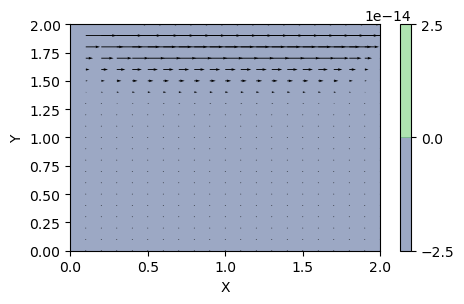

In [8]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p = cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

/home/cisse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: No contour levels were found within the data range.
  after removing the cwd from sys.path.


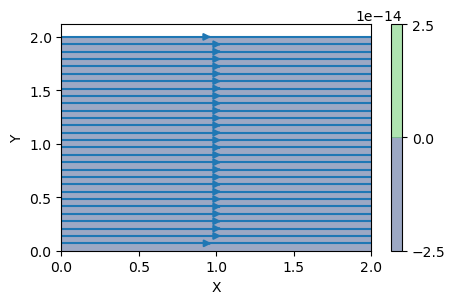

In [9]:
fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

## Call Funtions

## Pure python function

In [10]:
%timeit cavity_flow_pure(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

8.52 s ± 308 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numba accelerator

In [11]:
%timeit cavity_flow_numba(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

8.31 ms ± 79.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
